# Charm Analysis:

This analysis is done using `Coffea` (version 2024.10.0) and `Awkward Arrays`. This study will focus on the event selection of W+c Events.

In [1]:
import hist as h
import dask
import awkward as ak
import hist.dask as dhist
import dask_awkward as dak
import uproot
import numpy as np
import mplhep as mh
from coffea import processor
from coffea.nanoevents import NanoEventsFactory, NanoAODSchema
from coffea.nanoevents.methods import candidate
from coffea.dataset_tools import apply_to_fileset, preprocess
from matplotlib import pyplot as plt

In [2]:
events = NanoEventsFactory.from_root(
    {"../../datasets/nano106X_on_mini106X_2017_mc_NANOAOD_W1Jets_to_LNu_250K.root": "Events"},
    schemaclass=NanoAODSchema,
    metadata={"dataset":"WJets"},
    mode="dask"
).events()
events

/home/xondikoi/miniconda3/envs/Coffea_2025/lib/python3.12/site-packages/coffea/nanoevents/schemas/nanoaod.py:264: RuntimeWarning: Missing cross-reference index for LowPtElectron_electronIdx => Electron
  warnings.warn(
/home/xondikoi/miniconda3/envs/Coffea_2025/lib/python3.12/site-packages/coffea/nanoevents/schemas/nanoaod.py:264: RuntimeWarning: Missing cross-reference index for LowPtElectron_genPartIdx => GenPart
  warnings.warn(
/home/xondikoi/miniconda3/envs/Coffea_2025/lib/python3.12/site-packages/coffea/nanoevents/schemas/nanoaod.py:264: RuntimeWarning: Missing cross-reference index for LowPtElectron_photonIdx => Photon
  warnings.warn(


dask.awkward<from-uproot, npartitions=1>

In [3]:
# Defining the style for plots (CMS Style)
plt.style.use(mh.style.CMS)
plt.rcParams.update({
    "font.size": 14,
    "axes.labelsize": 14,
    "axes.titlesize": 14,
    "xtick.labelsize": 14,
    "ytick.labelsize": 14,
    "legend.fontsize": 14
})

# Histogram Function:
def make_hist(data, nBins, lo, hi, xLabel, yLabel, label, fname=None, logy=False):
    histogram = dhist.Hist(h.axis.Regular(nBins, lo, hi))
    fig, ax = plt.subplots(1 ,1, figsize=(6,4))
    histogram.fill(data)
    # histogram.compute().plot(ax=ax , yerr=False, label=label)  
    mh.histplot(histogram.compute(), ax=ax, label=label, yerr=False, histtype="step") 
    mh.cms.label("Open Data", data=True, lumi=None, com=13, year=2016, loc=0)
    ax.set_xlabel(xLabel)
    ax.set_ylabel(yLabel)
    ax.legend()
    if logy:
        ax.set_yscale("log")
    if fname:
        plt.savefig(fname)
    plt.show()

In [4]:
# RecoMuons:
RecoMuons = events.Muon
# MET:
MET = events.MET

## W $\rightarrow$ $\mu + \nu$ 

In [5]:
# Muon Selection Cuts: 
Selection_Cuts = (
    (RecoMuons.pt > 35) &
    (abs(RecoMuons.eta) < 2.4) &
    (abs(RecoMuons.pfRelIso04_all) < 0.15)  
    # (RecoMuons.tightId == 1)
)

# M_T Selection Cut:
Muon_Mt = np.sqrt(2 * RecoMuons.pt * MET.pt * (1 - np.cos(RecoMuons.phi - MET.phi)))
Selection_Cuts = Selection_Cuts & (Muon_Mt > 55)
Muons_Sel = RecoMuons[Selection_Cuts]

# Leading Muon Collection and Transverse Momentum:
Leading_Muons = dak.firsts(Muons_Sel)
none_val_mask = dak.is_none(Leading_Muons.pt) # all None values
Leading_Muons_Clean = Leading_Muons[~none_val_mask] # discard all none values
Leading_Muons_Clean_Pt = Leading_Muons_Clean.pt

# Number of Sorted Muons & passCuts for OS:
nMuons = dak.num(Muons_Sel)

# Sub-Leading Muon Collection and Transverse Momentum:
sublead_mask = nMuons > 1
Subleading_Muons = Muons_Sel[sublead_mask][:,1]

OS_mask = (ak.num(Muons_Sel.charge, axis=1) == 0) | (nMuons >=2) 
Selected_Muons_PassCuts = ~OS_mask 
 # Final Selection of Muons:
fMuons = Muons_Sel[Selected_Muons_PassCuts]

In [7]:
# W_Bosons = events.

## Before Kinematic Cuts:

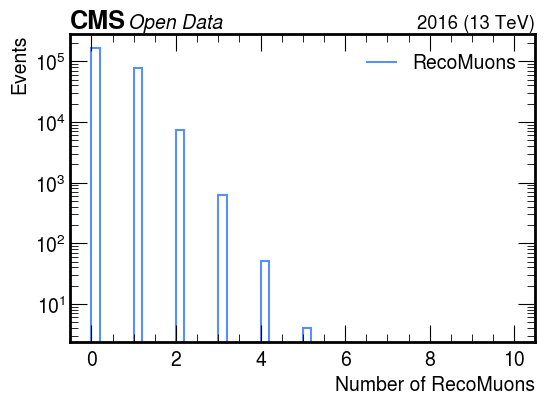

In [8]:
# Number of Muons before any Selection cuts:
nRecoMuons = dak.num(RecoMuons.pt)
make_hist(
    nRecoMuons,
    50, 0, 10,
    "Number of RecoMuons",
    "Events",
    "RecoMuons",
    fname="Plots/nRecoMuons_woCuts.png",
    logy=True
)

## Reco Muons Pt, Eta and Phi wihtout any kinematic cuts:

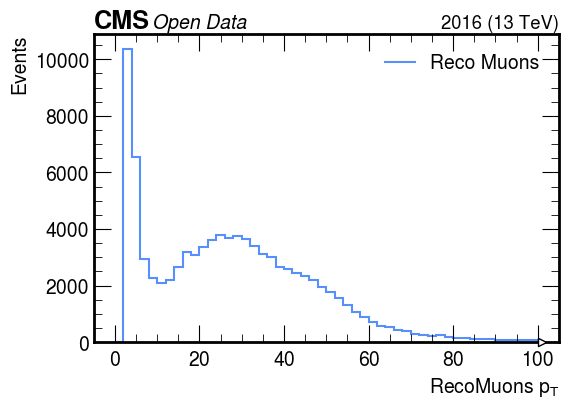

In [9]:
RecoMuons_Pt = dak.flatten(RecoMuons.pt)
make_hist(
    RecoMuons_Pt,
    50, 0, 100,
    "RecoMuons $p_{T}$",
    "Events",
    "Reco Muons",
    fname=None,
    logy=False
)

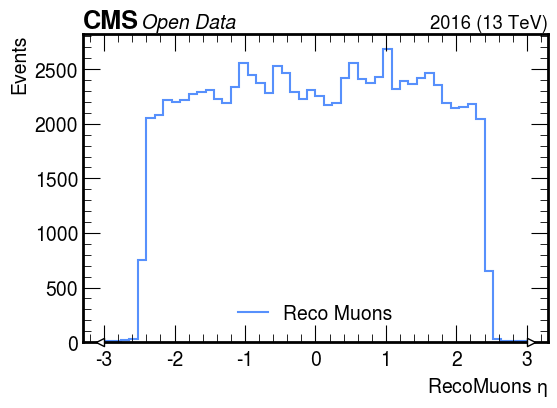

In [10]:
RecoMuons_Eta = dak.flatten(RecoMuons.eta)
make_hist(
    RecoMuons_Eta,
    50, -3, 3,
    "RecoMuons $\\eta$",
    "Events",
    "Reco Muons",
    fname=None,
    logy=False
)

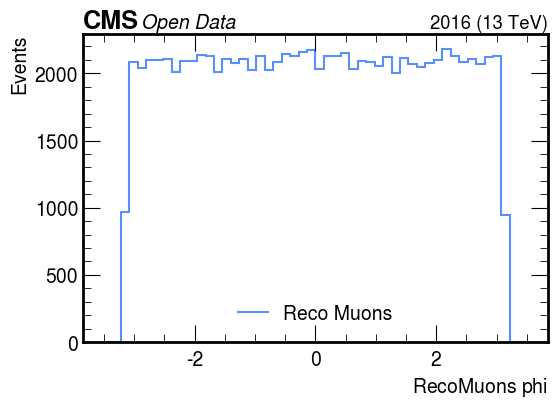

In [11]:
RecoMuons_Phi = dak.flatten(RecoMuons.phi)
make_hist(
    RecoMuons_Phi,
    50, -3.5, 3.5,
    "RecoMuons $phi$",
    "Events",
    "Reco Muons",
    fname=None,
    logy=False
)

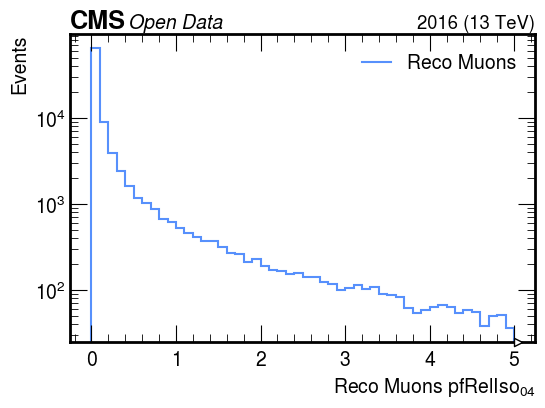

In [12]:
# RecoMuons pfRelIso04:
RecoMuons_pfRelIso04 = dak.flatten(RecoMuons.pfRelIso04_all)
make_hist(
    RecoMuons_pfRelIso04,
    50, 0, 5,
    "Reco Muons $pfRelIso_{04}$",
    "Events",
    "Reco Muons",
    fname=None,
    logy=True
)

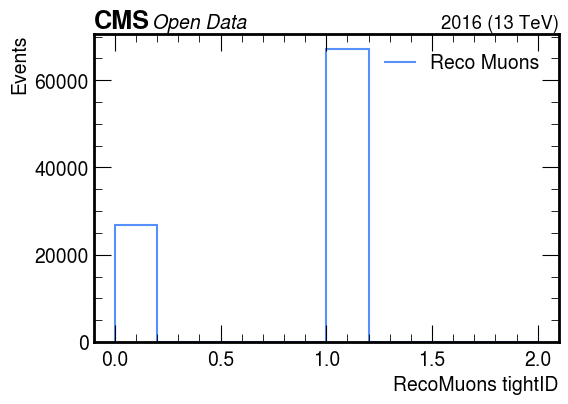

In [13]:
# RecoMuons isTightID:
RecoMuons_tightID = dak.flatten(RecoMuons.tightId)
make_hist(
    RecoMuons_tightID,
    10, 0, 2,
    "RecoMuons tightID",
    "Events",
    "Reco Muons",
    fname=None,
    logy=False
)

## After Kinematic Cuts:

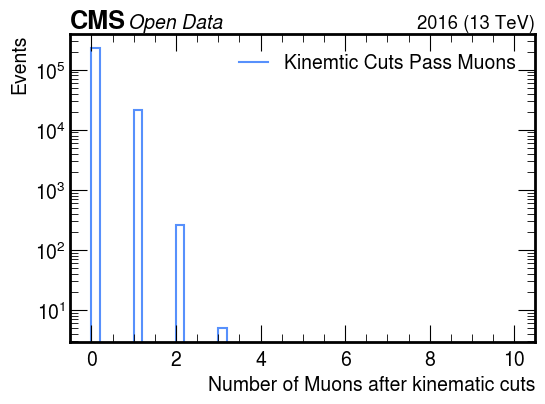

In [14]:
# Number of Muons after Kinematic Cuts:
nMuons_Sel = dak.num(Muons_Sel.pt)
make_hist(
    nMuons_Sel,
    50, 0, 10,
    "Number of Muons after kinematic cuts",
    "Events",
    "Kinemtic Cuts Pass Muons",
    fname="Plots/nMuons_woTightID.png",
    logy=True
)

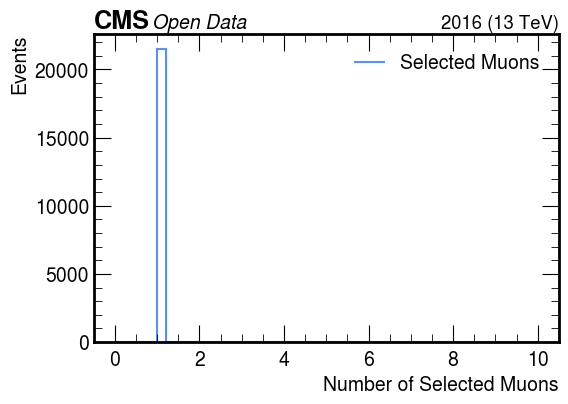

In [15]:
# Number of Muons after final selection:
nFinalMuons = dak.num(fMuons.pt)
make_hist(
    nFinalMuons,
    50, 0, 10,
    "Number of Selected Muons",
    "Events",
    "Selected Muons",
    fname=None,
    logy=False
)

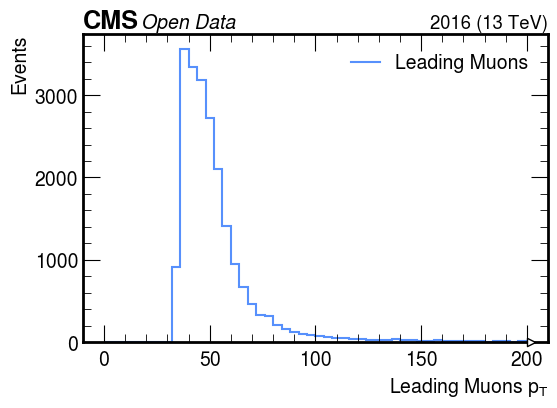

In [16]:
# Leading Muons Pt:
make_hist(
    Leading_Muons_Clean_Pt,
    50, 0, 200,
    "Leading Muons $p_{T}$",
    "Events",
    "Leading Muons",
    fname=None,
    logy=False
)

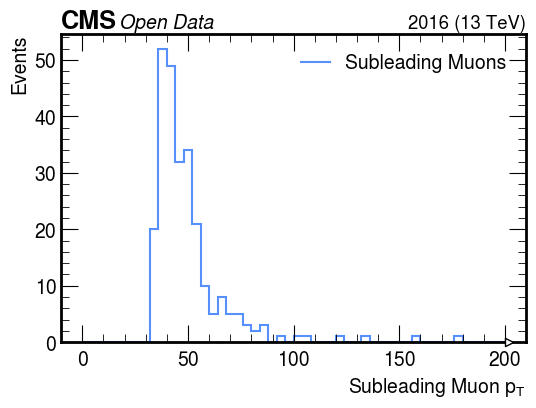

In [17]:
# Subleading Muons Pt:
Subleading_Muon_Pt = Subleading_Muons.pt
make_hist(
    Subleading_Muon_Pt,
    50, 0, 200,
    "Subleading Muon $p_{T}$",
    "Events",
    "Subleading Muons",
    fname=None,
    logy=False
)

In [18]:
# fMuons are Muons from W Bosons:
WBos_Mu = fMuons
WBos_Mu.pt.compute()

<Array [[57], [49.7], ..., [57.5], [73]] type='21520 * var * float32[parame...'>

All events passing these muon selections for W Bosons need to be stored now, so that we can do the **OS - SS** selection.

## c $\rightarrow$ $\mu$ + Anything:

In [19]:
# RecoJet Collection:
RecoJets = events.Jet

In [25]:
# Muon Selection Cuts:
Muon_PassCuts = (
    (abs(RecoMuons.eta) < 2.4) &
    (RecoMuons.pt < 25) &
    (abs(RecoMuons.pfRelIso04_all) > 0.2) &
    (RecoMuons.jetIdx >= 0)
)
Jet_Muons = RecoMuons[Muon_PassCuts]

In [37]:
Jet_Muons_Padded = dak.pad_none(Jet_Muons, 2, axis=1)
valid_mask = ~dak.is_none(Jet_Muons_Padded[:,0]) & ~dak.is_none(Jet_Muons_Padded[:,1])
dimuon_events = Jet_Muons_Padded[valid_mask]

# Dimuon mass:
dimuon_mass = (dimuon_events[:,0] + dimuon_events[:,1]).mass

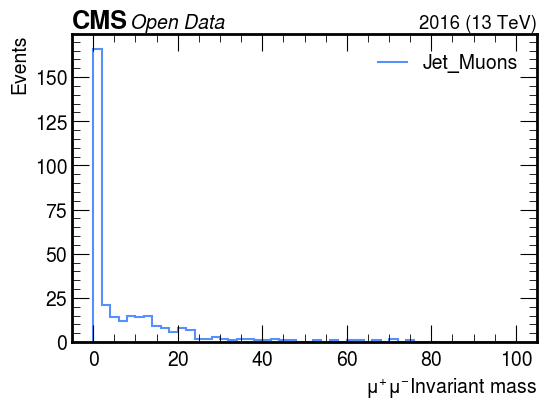

In [38]:
make_hist(
    dimuon_mass,
    50, 0, 100,
    "$\\mu^{+} \\mu^{-}$Invariant mass",
    "Events",
    "Jet_Muons",
    fname=None,
    logy=False
)

In [41]:
# Dimuon mass cut:
mass_Cut = (
    (dimuon_mass > 12) & (dimuon_mass < 80)
    )
fJet_Muons = Jet_Muons[mass_Cut]

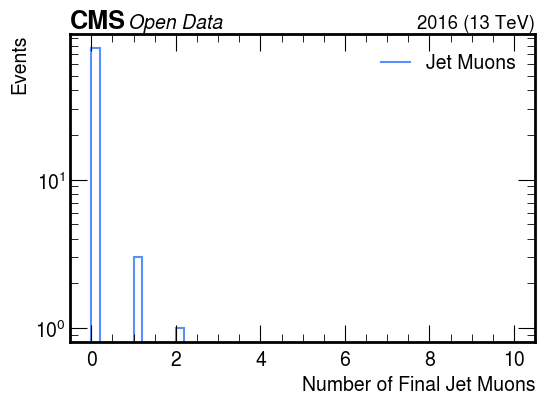

In [ ]:
# Number of Selected Jet Muons:
nfJet_Muons = dak.num(fJet_Muons.pt)
make_hist(
    nfJet_Muons,
    50, 0, 10,
    "Number of Final Jet Muons",
    "Events",
    "Jet Muons",
    fname=None,
    logy=True
)

In [ ]:
# OS events: Signal-like & SS events: Background-like:


In [22]:
import coffea
print(coffea.__version__)

2025.11.0
